In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import kaleido
import itertools
from tqdm import tqdm
from shapely.geometry import Polygon
from pykrige.ok import OrdinaryKriging
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px




os.environ['USE_PYGEOS'] = '0'

c:\Users\jgidn\Documents\Summer Project\KidSatExt\.venv\Lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\jgidn\AppData\Local\Temp\ipykernel_30324\302696252.py:5: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch shoul

In [2]:
path = "C://Users/jgidn/Documents/Summer Project/orphanhood_predictions.csv"
df= pd.read_csv(path)
df = df[['lat','lon','orphaned']]

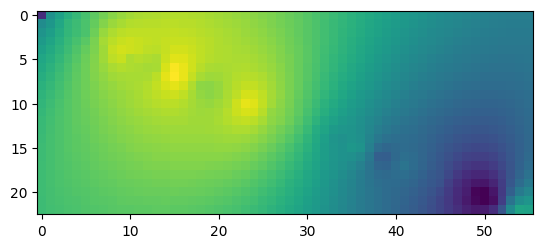

In [3]:
g_df = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=gpd.points_from_xy(df["lon"], df["lat"]))

g_df = g_df.to_crs("EPSG:3347")
g_df["Easting"], g_df["Northing"] = g_df.geometry.x, g_df.geometry.y
resolution = 20000  # cell size in meters
gridx = np.arange(g_df.bounds.minx.min(), g_df.bounds.maxx.max(), resolution)
gridy = np.arange(g_df.bounds.miny.min(), g_df.bounds.maxy.max(), resolution)

# Interpolate
krig = OrdinaryKriging(x=g_df["Easting"], y=g_df["Northing"], z=g_df['orphaned'], variogram_model="spherical",
    # drift_terms=['regional_linear']
                        )
z, ss = krig.execute("grid", gridx, gridy)
z= z.clip(0,1)
plt.imshow(z);

In [4]:
def pixel2poly(x, y, z, resolution):
    """
    x: x coords of cell
    y: y coords of cell
    z: matrix of values for each (x,y)
    resolution: spatial resolution of each cell
    """
    polygons = []
    values = []
    half_res = resolution / 2
    for i, j  in (itertools.product(range(len(x)), range(len(y)))):
        minx, maxx = x[i] - half_res, x[i] + half_res
        miny, maxy = y[j] - half_res, y[j] + half_res
        polygons.append(Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)]))
        if isinstance(z, (int, float)):
            values.append(z)
        else:
            values.append(z[j, i])
    return polygons, values


mean = df.orphaned.mean()
std = df.orphaned.std()

#'gadm41_KEN_shp/gadm41_KEN_2.shp'
zm_map_shape = "C:/Users/jgidn/Documents/Summer Project/gadm41_ZMB_shp/gadm41_ZMB_2.shp"
gdf = gpd.read_file(zm_map_shape)
gdf.to_file("C:/Users/jgidn/Documents/Summer Project/gadm41_ZMB_shp/gadm41_ZMB_2.geojson", driver="GeoJSON")
gdf_json = gpd.read_file("C:/Users/jgidn/Documents/Summer Project/gadm41_ZMB_shp/gadm41_ZMB_2.geojson")


def get_coords(row):
    x_list = row.geometry.geoms[0].exterior.coords.xy[0]
    y_list = row.geometry.geoms[0].exterior.coords.xy[1]

    return (np.array(x_list),np.array(y_list))

In [6]:
polygons, values = pixel2poly(gridx, gridy, z, resolution)
values_percent = [100*val for val in values]
kenya_model = (gpd.GeoDataFrame({"Orphanhood %": values_percent}, geometry=polygons, crs="EPSG:3347")
                   .to_crs("EPSG:4326")
               )
kenya_model = gpd.clip(kenya_model,gdf)
fig = px.choropleth_mapbox(kenya_model, geojson=kenya_model.geometry, locations=kenya_model.index,
                           color="Orphanhood %", color_continuous_scale="Viridis",
                           range_color=[0,100],
                           center={"lat": 0.0236, "lon": 37.9062}, zoom=5,
                           mapbox_style="white-bg")
fig.update_layout(coloraxis_showscale=False)
fig.update_traces(marker_line_width=0)


fig.add_trace(go.Choroplethmapbox(
    geojson=gdf.__geo_interface__,
    locations=gdf.index,
    z=gdf.index,  # This is just a placeholder, we're not actually coloring by this
    colorscale=[[0, 'rgba(0,0,0,0)'], [1, 'rgba(0,0,0,0)']],  # Transparent fill
    marker_line_color='black',
    marker_line_width=0.5,
    showscale=False,
))
fig.update_layout(margin=dict(l=0, r=0, t=30, b=10))
fig.write_image("C:/Users/jgidn/Documents/Summer Project/orphanhood_zambia.pdf")

AttributeError: 'Figure' object has no attribute 'plot'